#  Homework 2

## Rui Fang $\quad$ Collaborator: Yudi (Judy) Wang


**Due Date: ** Friday, Febrary 9th, 2017 at 10am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)

***

### *Solution*

### Inverse transform sampling

Based on the pdf $f_X(x)$, we can calculate the cdf of the random variable $X$:

$$
F_X(x) = 
\begin{cases}
0, & x < 1\\
\frac{1}{24}(x-1)^2, &1\leq x\leq 3\\
-\frac{1}{24}(x-5)^2+\frac{1}{3}, &3< x\leq 5\\
\frac{1}{12}(x-5)^2+\frac{1}{3}, &5< x\leq 7\\
-\frac{1}{12}(x-9)^2+1, &7< x\leq 9\\
1, &x > 9.
\end{cases}
$$

To estimate $\mathbb{E}[h(X)]$ via inverse sampling, we need to sample $x$ by the following steps: 
1. get a sample $u$ from $Unif(0,1)$
2. solve for $x$ using $x=F^{-1}(u)$ where $F$ is the cdf of $x$
3. repeat

then compute $h(x)$ for the sampled x's, calculate the mean, repeat this procedure for a number of times, and then estimate the mean of the means. 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Define h(x)
h = lambda x: 1 / (3*np.sqrt(2)*np.pi) * np.exp(-(x-5)**2 / 18)

# Define the pdf f_X(x)
def f_X(x):
    if x < 1 or x > 9:
        fx = 0
    elif x <= 3:
        fx = (x-1)/12
    elif x <= 5:
        fx = -(x-5)/12
    elif x <= 7:
        fx = (x-5)/6
    else:
        fx = -(x-9)/6
    return fx

# Define the inverse cdf F^-1(u)
def invCDF(u):
    if u <= 1/6:
        x = np.sqrt(24*u) + 1
    elif u <= 1/3:
        x = - np.sqrt(-24*(u-1/3)) + 5
    elif u <= 2/3:
        x = np.sqrt(12*(u-1/3)) + 5
    else:
        x = - np.sqrt(-12*(u-1)) + 9
    return x

# Function to sample x from the distribution f_X(x) via inverse sampling
def inverse_sampling(sample_size):
    
    # Generate uniform samples in range [0,1] and then invert the cdf to get samples of x
    U = np.random.uniform(0, 1, sample_size)
    X = np.array([invCDF(u) for u in U])

    return X

In [24]:
num_sampling = 1000
sample_size = 100

means_iv = np.zeros(num_sampling)
for i in range(num_sampling): 
    means_iv[i] = np.mean(h(inverse_sampling(sample_size)))

print('Estimate of E[h(x)]:', np.mean(means_iv))
print('Variance of estimate:', np.var(means_iv))

Estimate of E[h(x)]: 0.0589034052647
Variance of estimate: 1.04073071214e-06


### Rejection sampling with uniform proposal distribution

This time we sample $x$ by rejection sampling: 
1. draw $x$ uniformly from $[x_{min}, x_{max}]$ (uniform proposal distribution)
2. draw $y$ uniformly from $[0, y_{max}]$
3. if $y < f(x)$, accept the sample; otherwise reject it
4. repeat 

In [4]:
# Function to sample x from the distribution f_X(x) via rejection sampling with uniform proposal dist. 
# (part of the code referenced the example code given in AM207 lecture)
def rejection_sampling_uniform(sample_size):

    # domain limits
    xmin = 1  # the lower limit of our domain
    xmax = 9  # the upper limit of our domain

    # range limit (supremum) for y
    ymax = 1/3

    X = np.zeros(sample_size)    
    accepted = 0  # the number of accepted samples
    count = 0  # the total count of proposals

    # generation loop
    while (accepted < sample_size):

        # pick a uniform number on [xmin, xmax)
        x = np.random.uniform(xmin, xmax)

        # pick a uniform number on [0, ymax)
        y = np.random.uniform(0, ymax)

        # Do the accept/reject comparison
        if y < f_X(x):
            X[accepted] = x
            accepted += 1

        count +=1

#     print("Count",count, "Accepted", accepted)
    
    return X

In [23]:
num_sampling = 1000
sample_size = 100

means_rj_uni = np.zeros(num_sampling)
for i in range(num_sampling): 
    means_rj_uni[i] = np.mean(h(rejection_sampling_uniform(sample_size)))

print('Estimate of E[h(x)]:', np.mean(means_rj_uni))
print('Variance of estimate:', np.var(means_rj_uni))

Estimate of E[h(x)]: 0.0588156618794
Variance of estimate: 1.02925127245e-06


### Rejection sampling with normal proposal distribution

We propose a normal distribution $g(x)$ with mean=7 and std=4 to sample $x$. This is because the distribution of interest $f(x)$ peaks at $x=7$. Scaling $g(x)$ appropriately to make the supremum $M$ of $f/g$ over $[x_{min}, x_{max}]$ equal to 1, we obtain 

$$ g(x) = \frac{1}{3} exp{\left(-\frac{(x-7)^2}{2*4^2}\right)}.$$

Then we can sample $x$ by rejection sampling: 
1. Draw x from the proposal distribution g(x) within $[x_{min}, x_{max}]$
2. Draw y uniformly from [0, 1]
3. if y < f(x)/Mg(x), accept the sample; otherwise reject it
4. repeat

<IPython.core.display.Javascript object>


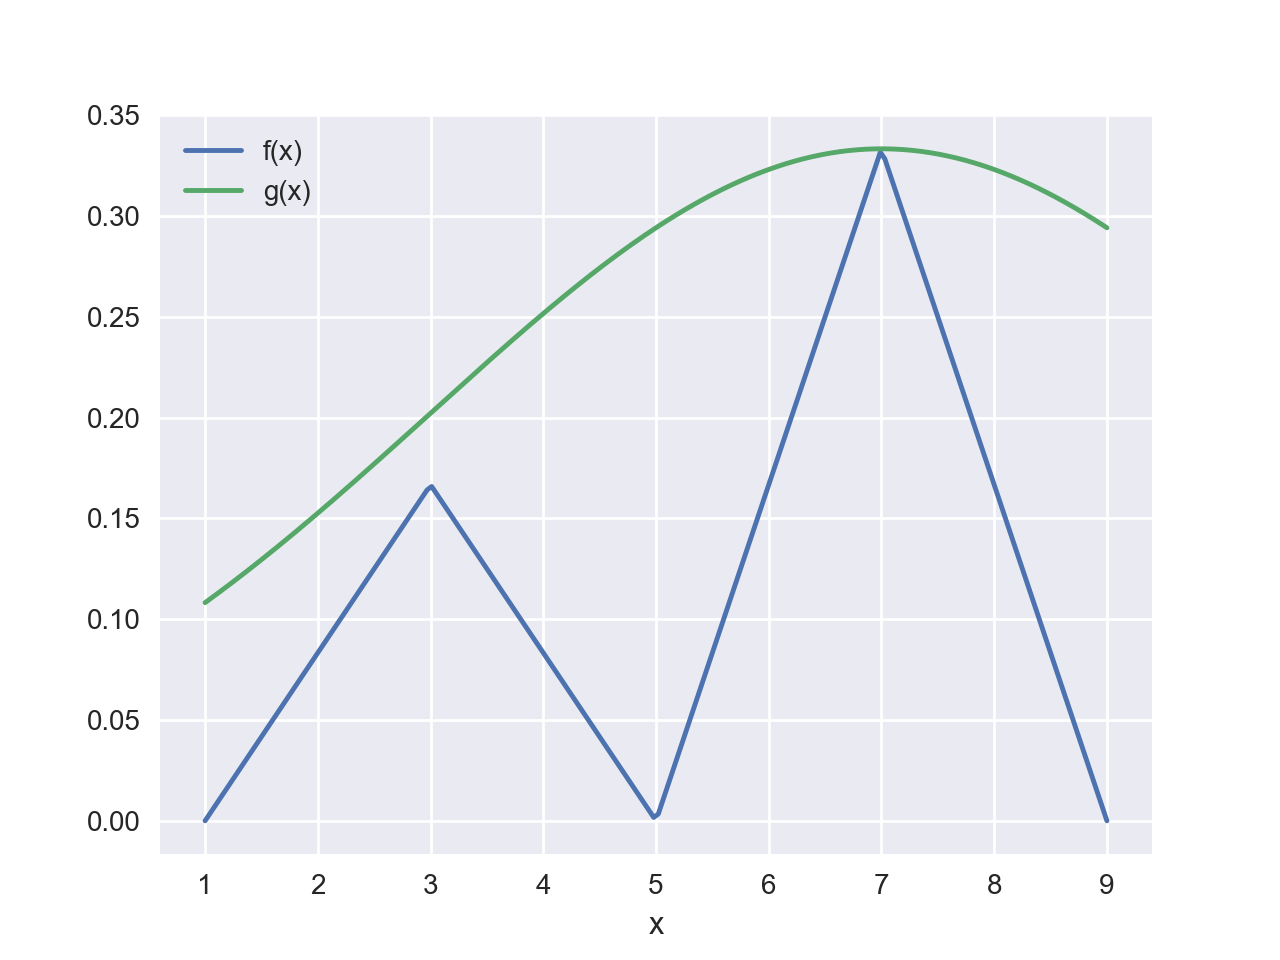

In [66]:
# Proposal distribution function 
g = lambda x: 1/3 * np.exp(-(x-7)**2/32)

# Plot f(x) and g(x)
plt.figure()
xx = np.linspace(1, 9, 200)
fx = np.array([f_X(x) for x in xx])
plt.plot(xx, fx, label='f(x)')
plt.plot(xx, g(xx), label='g(x)')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

In [6]:
# Function to sample x from the distribution f_X(x) via rejection sampling with normal proposal dist. 
# (part of the code referenced the example code given in AM207 lecture)
def rejection_sampling_normal(sample_size):

    # domain limits
    xmin = 1  # the lower limit of our domain
    xmax = 9  # the upper limit of our domain

    # our proposal distribution (choosing M to be 1 so it's unnormalized) 
    g = lambda x: 1/3 * np.exp(-(x-7)**2/32)

    X = np.zeros(sample_size)
    accepted = 0  # the number of accepted samples
    count = 0  # the total count of proposals

    # generation loop
    while (accepted < sample_size):

        # sample from normal distribution with mu=7, std=4 and ensure it is in range [xmin, xmax]
        x = np.random.normal(loc=7, scale=4) 
        if x < xmin or x > xmax: 
            continue

        # pick a uniform number on [0, 1)
        y = np.random.uniform(0, 1)

        # Do the accept/reject comparison
        if y < f_X(x)/g(x):
            X[accepted] = x
            accepted += 1

        count +=1

#     print("Count",count, "Accepted", accepted)
    
    return X

In [22]:
num_sampling = 1000
sample_size = 100

means_rj_nm = np.zeros(num_sampling)
for i in range(num_sampling): 
    means_rj_nm[i] = np.mean(h(rejection_sampling_normal(sample_size)))

print('Estimate of E[h(x)]:', np.mean(means_rj_nm))
print('Variance of estimate:', np.var(means_rj_nm))

Estimate of E[h(x)]: 0.0588693887174
Variance of estimate: 1.07842528556e-06


Therefore, using three sampling methods, $\mathbb{E}[h(X)]$ is estimated as follows:


| Sampling method       | $\mathbb{E}[h(X)]$ estimate |  variance of estimate |
| ------------- |:-------------:|:-------------:|
| Inverse sampling |  0.0589034052647 | 1.04073071214e-06|
| Rejection sampling with uniform proposal dist.| 0.0588156618794| 1.02925127245e-06|
| Rejection sampling with normal proposal dist.| 0.0588693887174 | 1.07842528556e-06|

***

## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. What do you see?

***
### *Solution*

See Problem 1 results for the variance. The variances of the estimates of all three methods are pretty close. They have the same order of magnitude. 

***
### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

2. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

***

### *Solution*

Divide the domain of $X$ into four pieces: $D_1 = [1,3]$, $D_2 = (3,5]$, $D_3 = (5,7]$, $D_4 = (7,9]$. Then we can express 

$$\mathbb{E}[h(X)] = \sum_{j=1}^4 p_j \mu_j = \sum_{j=1}^4 p_j \int_{D_j} h(x)f_j(x)dx, $$

where 
$$p_j = \int_{D_j} f(x)dx, \quad f_j(x) = \frac{f(x)}{p_j}.$$

Given the pdf $f(x)$ in Problem 1, we have

$$
\begin{align}
p_1 = \int_1^3 \frac{1}{12}(x-1) dx = \frac{1}{6}, & \quad f_1(x) = \frac{1}{2}(x-1), \\
p_2 = \int_3^5 -\frac{1}{12}(x-5) dx = \frac{1}{6}, & \quad f_2(x) = -\frac{1}{2}(x-5), \\
p_3 = \int_5^7 \frac{1}{6}(x-5) dx = \frac{1}{3}, & \quad f_3(x) = \frac{1}{2}(x-5), \\
p_4 = \int_7^9 -\frac{1}{6}(x-9) dx = \frac{1}{3}, & \quad f_4(x) = -\frac{1}{2}(x-9). \\
\end{align}
$$

Thus, $$\mathbb{E}[h(X)] = \frac{1}{6} \int_1^3 h(x)f_1(x) dx + \frac{1}{6} \int_3^5 h(x)f_2(x) dx + \frac{1}{3} \int_5^7 h(x)f_3(x) dx + \frac{1}{3} \int_7^9 h(x)f_4(x) dx.$$

<IPython.core.display.Javascript object>


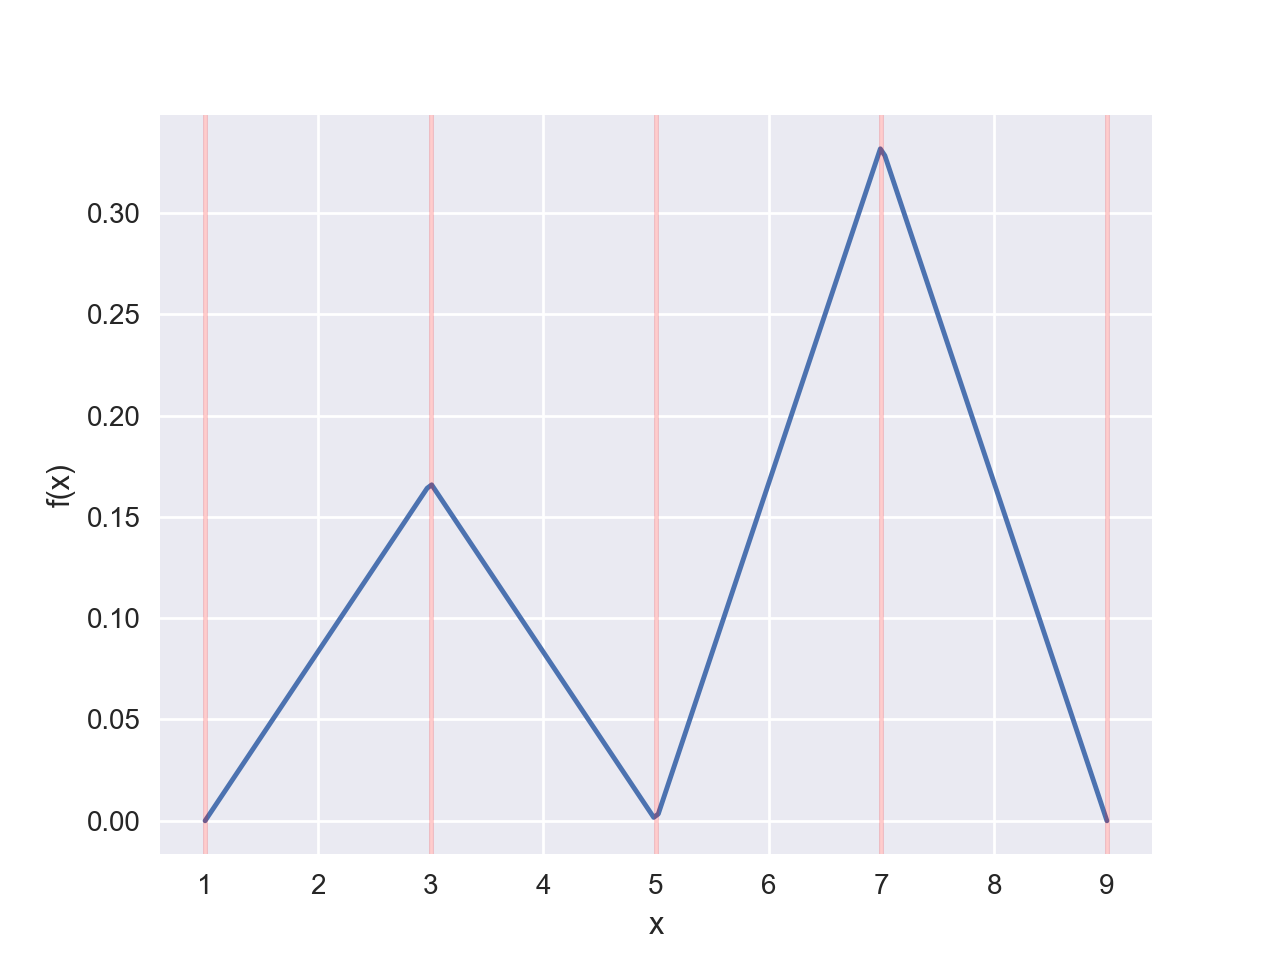

In [8]:
# Plot f(x) to visualize the strata 
xmin = 1
xmax = 9
step = 2
Ns = 4  # Number of strata

plt.figure()
xx = np.linspace(xmin, xmax, 200)
fx = np.array([f_X(x) for x in xx])
plt.plot(xx, fx)
for j in range(Ns+1):
    plt.axvline(xmin + j*step, 0, 1, color='r', alpha=0.2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Next, estimate each integral using rejection sampling with normal proposal distribution. We choose a normal distribution with mean=3 and std=1 for $f_1(x)=\frac{1}{2}(x-1)$ and $f_2(x)=-\frac{1}{2}(x-5)$, and a normal distribution with mean=7 and std=1 for $f_3(x)=\frac{1}{2}(x-5)$ and $f_4(x)=-\frac{1}{2}(x-9)$. The normal distribution pdfs are scaled to generate proposal function $g$'s such that the supremum of each $f/g$ is equal to 1.  

<IPython.core.display.Javascript object>


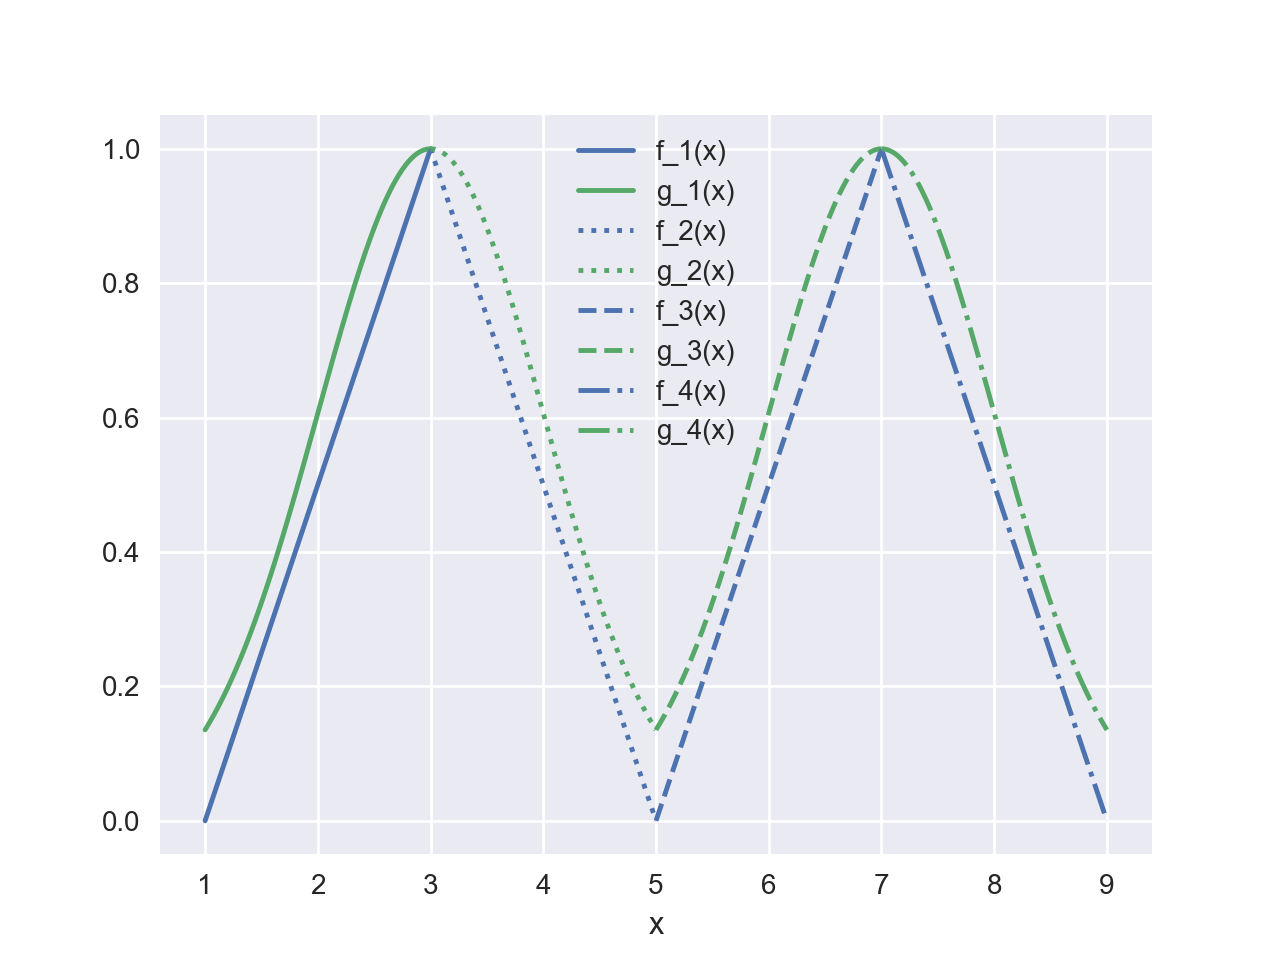

In [12]:
from scipy.stats import norm 

f1 = lambda x: 0.5*(x-1)
f2 = lambda x: -0.5*(x-5)
f3 = lambda x: 0.5*(x-5)
f4 = lambda x: -0.5*(x-9)

g1 = lambda x: f1(3)/norm.pdf(3, loc=3, scale=1) * norm.pdf(x, loc=3, scale=1) 
g2 = lambda x: f3(7)/norm.pdf(7, loc=7, scale=1) * norm.pdf(x, loc=7, scale=1)

# Plot pdf and proposal function for each stratum 
plt.figure()
xx1 = np.linspace(1, 3, 200)
xx2 = np.linspace(3, 5, 200)
xx3 = np.linspace(5, 7, 200)
xx4 = np.linspace(7, 9, 200)
plt.plot(xx1, f1(xx1), 'C0', ls='-', label='f_1(x)')
plt.plot(xx1, g1(xx1), 'C1', ls='-', label='g_1(x)')
plt.plot(xx2, f2(xx2), 'C0', ls=':', label='f_2(x)')
plt.plot(xx2, g1(xx2), 'C1', ls=':', label='g_2(x)')
plt.plot(xx3, f3(xx3), 'C0', ls='--', label='f_3(x)')
plt.plot(xx3, g2(xx3), 'C1', ls='--', label='g_3(x)')
plt.plot(xx4, f4(xx4), 'C0', ls='-.', label='f_4(x)')
plt.plot(xx4, g2(xx4), 'C1', ls='-.', label='g_4(x)')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

In [18]:
# Function to do rejection sampling with normal dist. for each stratum 
def rejection_sampling(sample_size, xmin, xmax, f, g, mu, std):
    
    X = np.zeros(sample_size)
    accepted = 0  # the number of accepted samples

    # generation loop
    while (accepted < sample_size):

        # sample from normal distribution ensure it is in range [xmin, xmax]
        x = np.random.normal(loc=mu, scale=std) 
        if x < xmin or x > xmax: 
            continue

        # pick a uniform number on [0, 1)
        y = np.random.uniform(0, 1)

        # Do the accept/reject comparison
        if y < f(x)/g(x):
            X[accepted] = x
            accepted += 1
    
    return X


num_sampling = 1000
sample_size = 100

# Probability of x being in each stratum 
p1 = 1/6
p2 = 1/6
p3 = 1/3
p4 = 1/3 

means_stratified = np.zeros(num_sampling)

for i in range(num_sampling):
    
    # Compute the expectation for each stratum 
    mu1 = np.mean(h(rejection_sampling(int(sample_size*p1), 1, 3, f1, g1, mu=3, std=1)))
    mu2 = np.mean(h(rejection_sampling(int(sample_size*p2), 3, 5, f2, g1, mu=3, std=1)))
    mu3 = np.mean(h(rejection_sampling(int(sample_size*p3), 5, 7, f3, g2, mu=7, std=1)))
    mu4 = np.mean(h(rejection_sampling(int(sample_size*p4), 7, 9, f4, g2, mu=7, std=1)))
    
    # Compute the overall expectation 
    means_stratified[i] = p1*mu1 + p2*mu2 + p3*mu3 + p4*mu4

In [19]:
print('Estimate of E[h(x)]:', np.mean(means_stratified))
print('Variance of estimate:', np.var(means_stratified))

Estimate of E[h(x)]: 0.0588294932043
Variance of estimate: 3.72055243458e-07


<IPython.core.display.Javascript object>


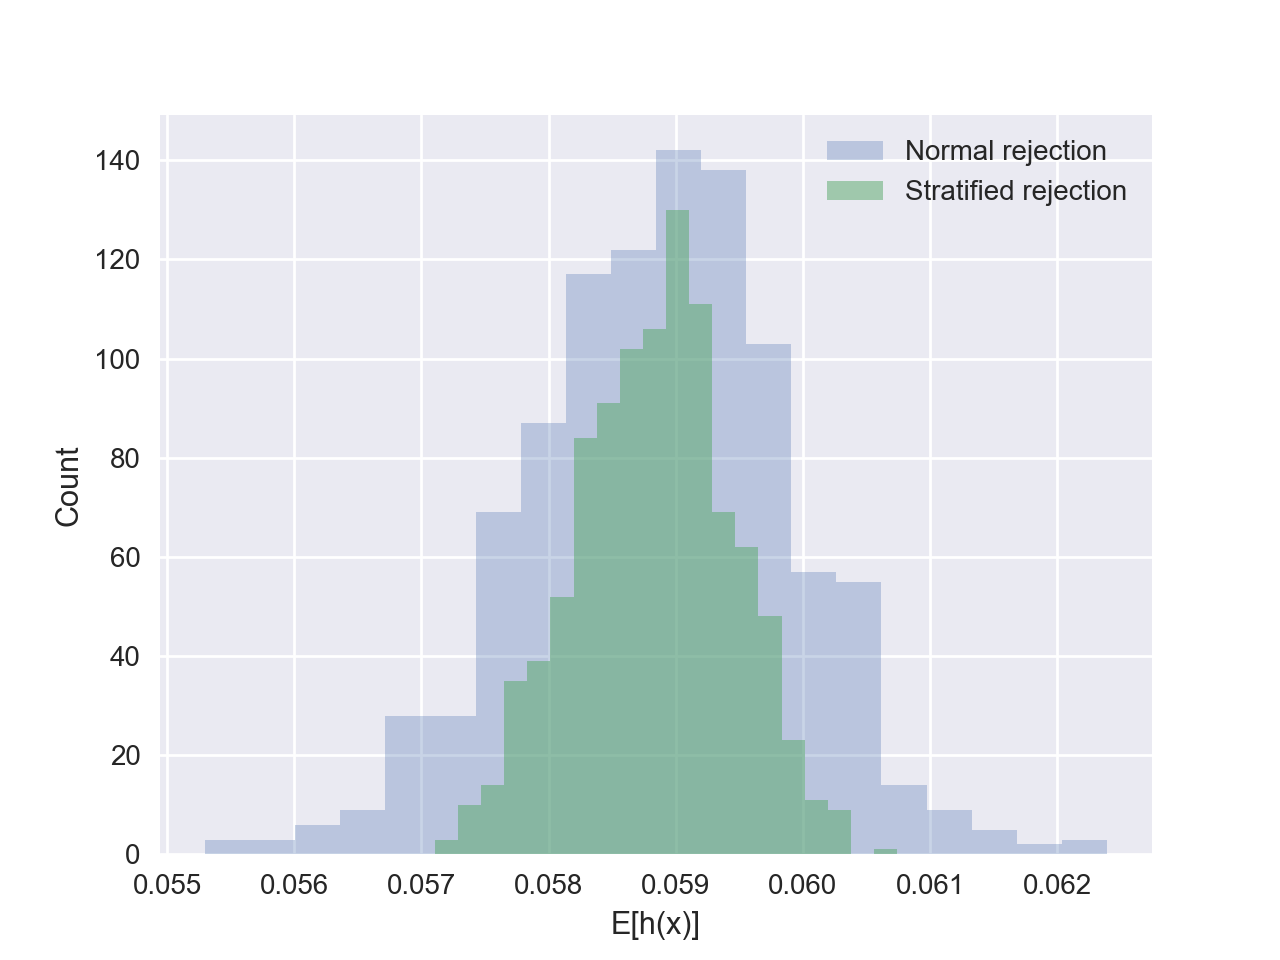

In [29]:
# Plot sampling distribution of E[h(x)] from stratified sampling and previous rejection sampling with normal 
# proposal distribution  
plt.figure()
plt.hist(means_rj_nm, 20, histtype='stepfilled', label=u'Normal rejection', alpha=0.3)
plt.hist(means_stratified, 20, histtype='stepfilled', label=u'Stratified rejection', alpha=0.5)
plt.xlabel('E[h(x)]')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

We find the variance of the estimate from stratified sampling is **smaller** than the variance from rejection sampling with normal proposal distribution. 
***

## Problem 3: Linear Regression

Consider the following base Regression class, which roughly follows the API in the python package `scikit-learn`.

Our model is the the multivariate linear model whose MLE solution or equivalent cost minimization was talked about in lecture:

$$y = X\beta + \epsilon$$
where $y$ is a length $n$ vector, $X$ is an $n \times p$ matrix created by stacking the features for each data point, and $\beta$ is a $p$ length vector of coefficients.

The class showcases the API:

$fit(X, y)$: Fits linear model to $X$ and $y$.

$get\_params()$: Returns $\hat{\beta}$ for the fitted model. The parameters should be stored in a dictionary with keys "intercept" and "coef" that give us $\hat{\beta_0}$ and $\hat{\beta_{1:}}$. (The second value here is thus a numpy array of coefficient values)

$predict(X)$: Predict new values with the fitted model given $X$.

$score(X, y)$: Returns $R^2$ value of the fitted model.

$set\_params()$: Manually set the parameters of the linear model.



In [45]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params[k]
    
    def set_params(self, **kwargs):
        for k,v in kwargs.iteritems():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()

### Part A:  a class for Ordinary Least Squares

Inherit from this class to create an ordinary Least Squares Linear Regression class. 

It's signature will look like this:

`class OLS(Regression):`

Implement `fit`, `predict` and `score`. This will involve some linear algebra. (You might want to read up on pseudo-inverses before you directly implement the linear algebra on the lecure slides).

#### $R^2$ score

To implement `score`, look below:

The $R^2$ score is defined as: $${R^{2} = {1-{SS_E \over SS_T}}}$$

Where:

$$SS_T=\sum_i (y_i-\bar{y})^2, SS_R=\sum_i (\hat{y_i}-\bar{y})^2, SS_E=\sum_i (y_i - \hat{y_i})^2$$
where  ${y_i}$ are the original data values, $\hat{y_i}$ are the predicted values, and $\bar{y_i}$ is the mean of the original data values.



***

### *Solution*

In [56]:
class OLS(Regression):
    
    def fit(self, X, y):
        
        # Stack a column of ones to the feature matrix in order to fit intercept
        X_new = np.hstack((np.ones(X.shape[0])[:, None], X))
        
        # Solve the normal equation using Moore-Penrose pseudo-inverse 
        weights = np.linalg.pinv(X_new).dot(y)
        
        # The first entry in the solved weights is intercept, the rest are coefficients 
        self.params['intercept'] = weights[0]
        self.params['coef'] = weights[1:]

        
    def predict(self, X, y):
        
        # Get intercept and coefficients 
        b0 = self.params['intercept']
        b1 = self.params['coef']
        
        # Return predictions
        return np.dot(X, b1) + b0
    
    def score(self, X, y):
        
        y_pred = self.predict(X, y)  # predicted values 
        y_ave = np.mean(y)  # mean of original values 
        
        # Compute SSE and SST 
        SSE = np.sum((y - y_pred)**2)
        SST = np.sum((y - y_ave)**2)
        
        # Return R^2 score 
        return 1-SSE/SST


***

### Part B: test your code

We'll create a synthetic data set using the code below. (Read the documentation for `make_regression` to see what is going on).

In [62]:
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=1, noise=2, coef=True)
coef

array([ 76.6568183 ,  77.67682678,  63.78807738,  19.3299907 ,
        59.01638708,  53.13633737,  28.77629958,  10.01888939,
         9.25346811,  59.55220395])

Verify that your code recovers these coefficients approximately on doing the fit. Plot the predicted `y` against the actual `y`. Also calculate the score using the same sets `X` and `y`. The usage will look something like:

```python
lr = OLS()
lr.fit(X,y)
lr.get_params('coef')
lr.predict(X,y)
lr.score(X,y)
```

***

### *Solution*

In [63]:
lr = OLS()
lr.fit(X, y)
lr.get_params('coef')

array([ 77.20719705,  76.51004831,  62.97865316,  18.4436452 ,
        58.50019885,  53.25126559,  28.29088241,   9.33333359,
        10.29584457,  59.1606719 ])

<IPython.core.display.Javascript object>


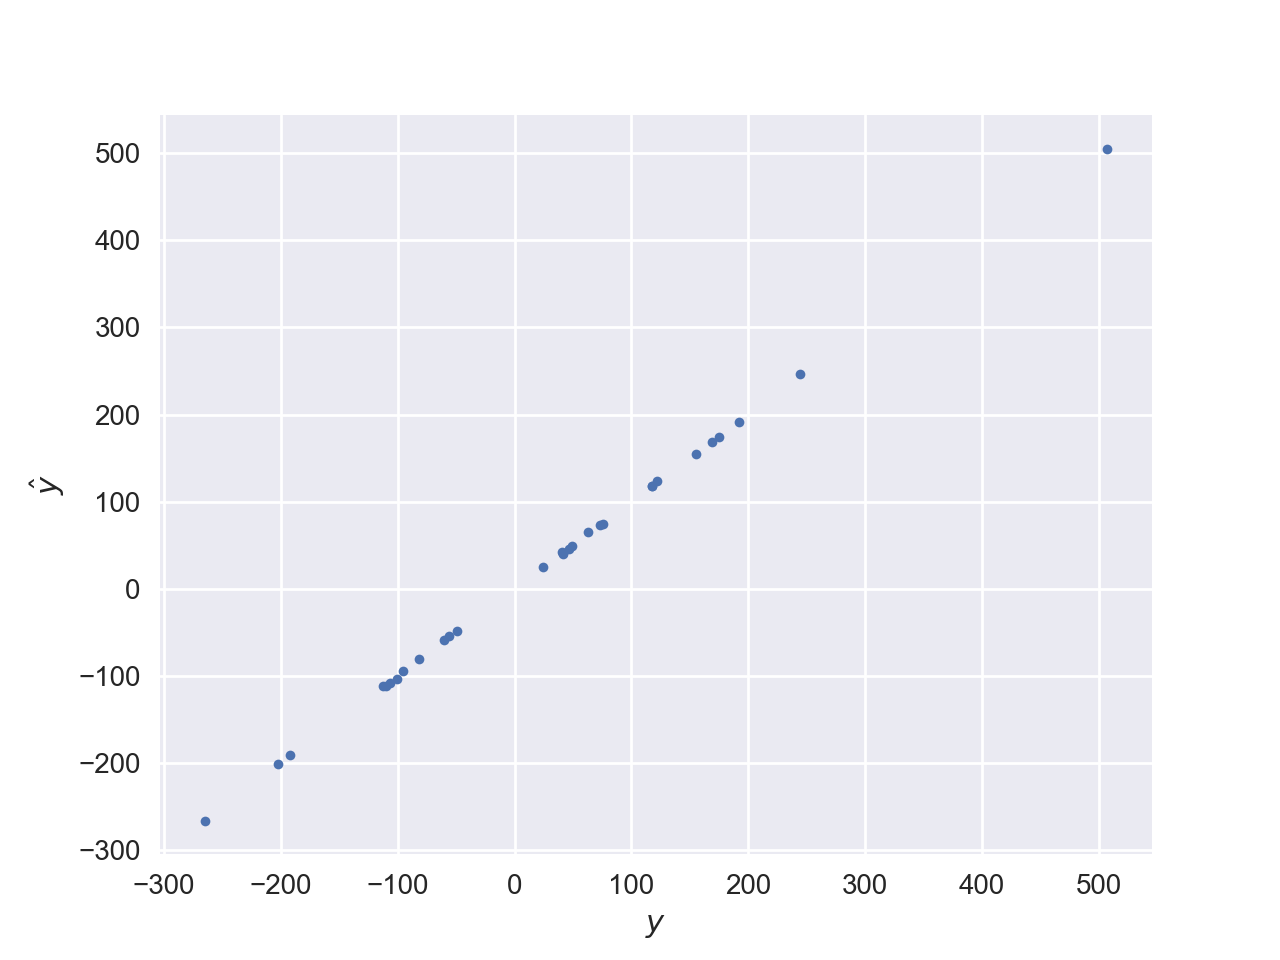

In [64]:
yhat = lr.predict(X, y)

# Plot predicted y against actual y 
plt.figure()
plt.plot(y, yhat, '.')
plt.xlabel(r'$y$')
plt.ylabel(r'$\hat{y}$')
plt.show()

In [65]:
print('R^2 score =', lr.score(X, y))

R^2 score = 0.999915583206


***